In [1]:
import numpy as np                                                    # Packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from scipy.ndimage import gaussian_filter1d
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
from scipy.sparse import csr_matrix
import scipy.io
from scipy.sparse import coo_matrix
import numpy as np
from decimal import Decimal, getcontext

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')

/tmp/ipykernel_15136/4253654759.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')


In [3]:
s_train = sd.train

In [4]:
neural_unit_index = []
spike_times = []

In [5]:
for index, array in enumerate(s_train):
    neural_unit_index.extend([index] * len(array))
    spike_times.extend(array)
    
result_array = np.column_stack((neural_unit_index, spike_times))

In [6]:
result_array[:,1] /= 1000

In [7]:
result_array[:, 0] += 1

In [8]:
len(np.unique(result_array[:, 0]))

72

In [9]:
dataset_5 = scipy.io.loadmat('Dataset_5_FCM.mat')
# dataset_5_spikes = data['spks']
# example_data = np.array(fig_4_spikes)

In [10]:
dataset_5

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Aug  1 21:36:00 2023',
 '__version__': '1.0',
 '__globals__': [],
 'FC_MAT': array([[0.00000000e+00, 0.00000000e+00, 2.76851730e-03, ...,
         0.00000000e+00, 0.00000000e+00, 4.57084177e-04],
        [4.63933372e-04, 0.00000000e+00, 7.14599232e-04, ...,
         0.00000000e+00, 5.78875085e-03, 0.00000000e+00],
        [3.97916140e-03, 0.00000000e+00, 0.00000000e+00, ...,
         5.19823297e-04, 1.02774970e-02, 3.64786849e-04],
        ...,
        [0.00000000e+00, 1.30224552e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.96898976e-04, 0.00000000e+00, 0.00000000e+00, ...,
         1.18719219e-03, 0.00000000e+00, 0.00000000e+00],
        [1.38286235e-05, 0.00000000e+00, 7.27556377e-04, ...,
         0.00000000e+00, 1.92851744e-03, 0.00000000e+00]])}

In [11]:
def createFCM(spksExc, spksInh=None):    
    
    # time constant of exponential profile (used for coupling)
    tau = 3e-3

    # 1e-4 binless window step in seconds
    step = 1e-4
    
    # store ids of neurons that really fired -- corresponding to entries in
    # adjacency relation
    
    if spksInh is None:
        old_ids = np.unique(spksExc[:, 0])
        spks = np.column_stack((spksExc, np.ones(len(spksExc))))
    else:
        old_ids = np.unique(np.concatenate((spksExc[:, 0], spksInh[:, 0])))
        spks = np.row_stack((np.column_stack((spksExc, np.ones(len(spksExc)))), 
                             np.column_stack((spksInh, -np.ones(len(spksInh))))))
        
    Eneuron_end = np.max(spksExc[:, 0])
    num_neurons = len(old_ids)
    
    row_indices = old_ids - 1  # Since Python uses 0-based indexing, we subtract 1 from old_ids
    col_indices = np.zeros_like(row_indices)
    values = np.arange(1, num_neurons + 1)

    new_ids = coo_matrix((values, (row_indices, col_indices)), shape=(num_neurons, 1))
    
    # frequency of spiking for individual neurons
    spike_freq = np.zeros(num_neurons)
    
    # duration of spike trains
    t_min = 0
    t_max = np.max(spksExc[:,1])
    T = t_max - t_min
    sig_length = np.ceil(T/step).astype(int)
    
    # Convert the new_ids sparse matrix to a dense NumPy array
    new_ids_array = new_ids.toarray().flatten()

    print(Eneuron_end)

    # Get spiking frequencies
    spike_freq = np.zeros(num_neurons)

    for i in range(1, num_neurons + 1):
        if i <= Eneuron_end:
            neuron_spikes = spksExc[spksExc[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
        else:
            if spksInh is None:
                print("spksInh is None. Make sure it is properly defined.")
                return None
                
            neuron_spikes = spksInh[spksInh[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
            
    # create signals for each neuron        
    signals = np.zeros((num_neurons, sig_length))
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        IorE = np.unique(spks[spks[:, 0] == k, 2])
        # how neuron i will influence other neurons
        signals[i - 1, :] = create_signal(spks[spks[:, 0] == k, 1], step, sig_length, tau, IorE)
    
    FC_MAT = np.zeros((num_neurons, num_neurons))
    spike_vecs = np.zeros((num_neurons, sig_length))

    # Previous code up to combining with discrete spiking events...

    # Combine with discrete spiking events
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        spike_times = spks[spks[:, 0] == k, 1]
        spike_times_vec = coo_matrix((np.ones_like(spike_times), 
                                      (np.ceil(spike_times / step).astype(int) - 1, 
                                       np.zeros_like(spike_times))), 
                                     shape=(sig_length, 1)).toarray().flatten()
        spike_vecs[i - 1, :] = spike_times_vec
        # Influence on neuron i from all other neurons.
        FC_MAT[:, i - 1] = signals.dot(spike_times_vec)

    # Thresholding
    FC_MAT[FC_MAT < 0] = 0
    FC_MAT = FC_MAT - np.diag(np.diag(FC_MAT))

    # Frequency normalization
    freq_normalization = spike_freq / np.maximum(spike_freq, 1)  # Divide element-wise with maximum value of 1
    freq_normalization[freq_normalization > 1] = 1

    FC_MAT = FC_MAT * freq_normalization

    return FC_MAT

In [12]:
def create_signal(start_times, dt, sig_length, tau, mode):
    # time vector
    t_vec = np.arange(dt, (sig_length + 1) * dt, dt)

    q = np.zeros_like(t_vec)

    if mode == 1:
        for k in range(len(start_times)):
            # t_vec - start_times[k]
            
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq
    else:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            qq = 1 - qq
            qq[qq > 0.99] = 0  # corresponds to ~4.5 tau
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq

    # due to rounding of spiking times, the exponential may sometimes not start at 1
    if mode == 1:
        idx = np.ceil(start_times / dt).astype(int) - 1
        idx = np.clip(idx, 0, len(q) - 1)  # Clip indices to be within valid range
        q[idx] = 1

    # shift to zero mean and make magnitude normalized
    q = q - np.mean(q)
    q = q / (np.max(q) * len(start_times))

    return q

In [13]:
FC_MAT = createFCM(result_array)

72.0


/tmp/ipykernel_7357/3072996499.py:9: RuntimeWarning: overflow encountered in exp
  qq = np.exp(-(t_vec - start_times[k]) / tau)


In [13]:
FC_MAT

array([[0.        , 0.        , 0.00276831, ..., 0.        , 0.        ,
        0.00045705],
       [0.00490294, 0.        , 0.00100146, ..., 0.        , 0.0058181 ,
        0.        ],
       [0.0300288 , 0.        , 0.        , ..., 0.00051975, 0.01027648,
        0.00036457],
       ...,
       [0.        , 0.01883247, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00206113, 0.        , 0.        , ..., 0.00118709, 0.        ,
        0.        ],
       [0.00068901, 0.        , 0.00480187, ..., 0.        , 0.00911224,
        0.        ]])

In [14]:
python_data = FC_MAT

In [20]:
matlab_data = dataset_5['FC_MAT']

In [21]:
python_data

array([[0.        , 0.        , 0.00276831, ..., 0.        , 0.        ,
        0.00045705],
       [0.00490294, 0.        , 0.00100146, ..., 0.        , 0.0058181 ,
        0.        ],
       [0.0300288 , 0.        , 0.        , ..., 0.00051975, 0.01027648,
        0.00036457],
       ...,
       [0.        , 0.01883247, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00206113, 0.        , 0.        , ..., 0.00118709, 0.        ,
        0.        ],
       [0.00068901, 0.        , 0.00480187, ..., 0.        , 0.00911224,
        0.        ]])

In [22]:
matlab_data

array([[0.00000000e+00, 0.00000000e+00, 2.76851730e-03, ...,
        0.00000000e+00, 0.00000000e+00, 4.57084177e-04],
       [4.63933372e-04, 0.00000000e+00, 7.14599232e-04, ...,
        0.00000000e+00, 5.78875085e-03, 0.00000000e+00],
       [3.97916140e-03, 0.00000000e+00, 0.00000000e+00, ...,
        5.19823297e-04, 1.02774970e-02, 3.64786849e-04],
       ...,
       [0.00000000e+00, 1.30224552e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.96898976e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.18719219e-03, 0.00000000e+00, 0.00000000e+00],
       [1.38286235e-05, 0.00000000e+00, 7.27556377e-04, ...,
        0.00000000e+00, 1.92851744e-03, 0.00000000e+00]])

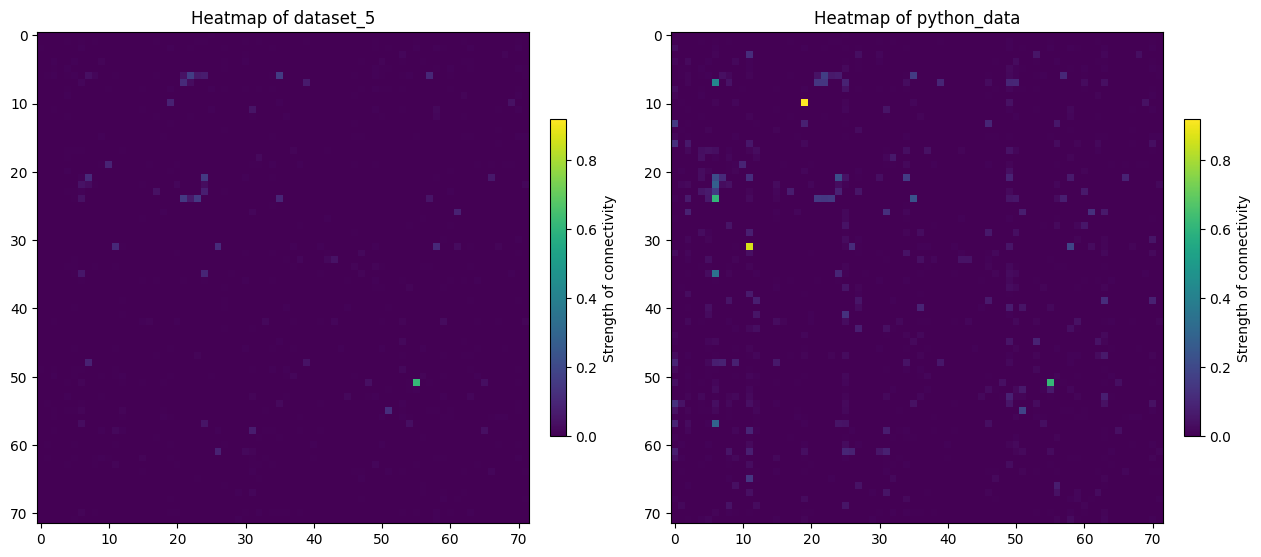

In [23]:
data_1 = dataset_5['FC_MAT']
data_2 = python_data

# Calculate the common vmin and vmax for both datasets
vmin = min(data_1.min(), data_2.min())
vmax = max(data_1.max(), data_2.max())

# Create a 1x2 subplot to place the heatmaps side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # Adjust the figure size as needed

# Plot the first heatmap (dataset_5)
heatmap1 = axs[0].imshow(data_1, cmap='viridis', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
axs[0].set_title('Heatmap of dataset_5')

# Plot the second heatmap (python_data)
heatmap2 = axs[1].imshow(data_2, cmap='viridis', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
axs[1].set_title('Heatmap of python_data')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('Strength of connectivity')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

plt.show()

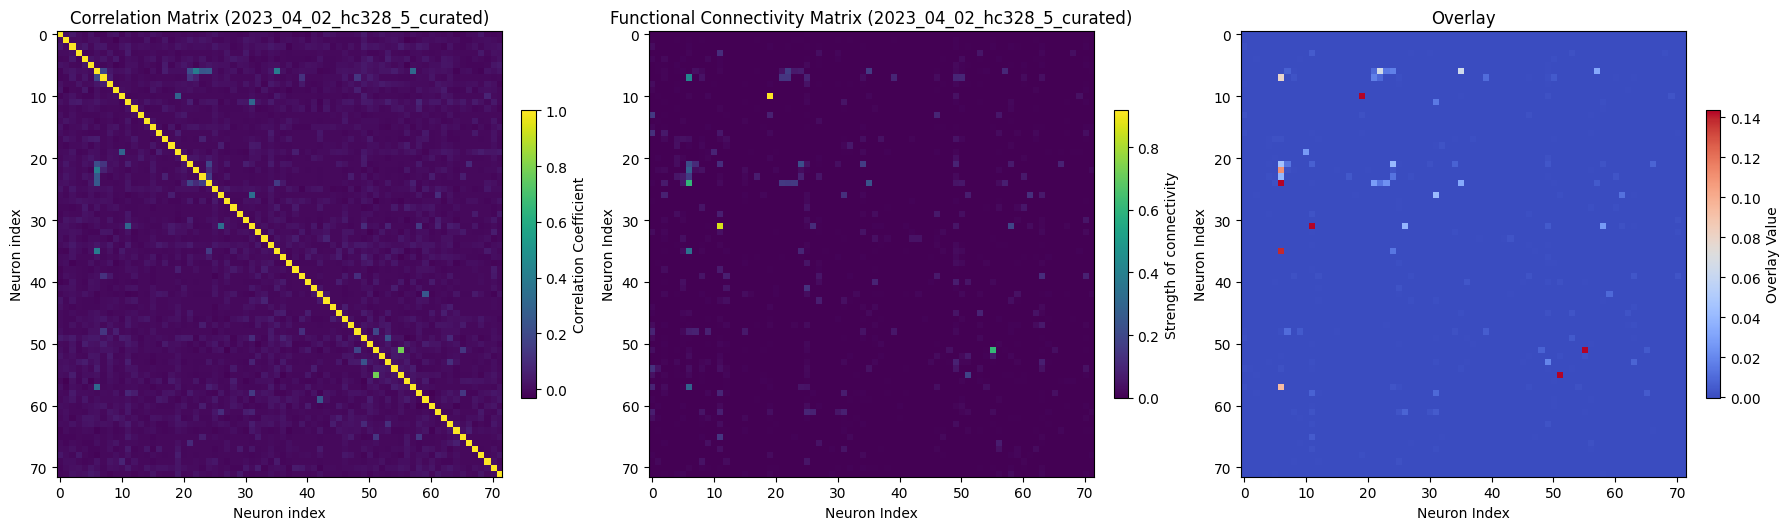

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N, sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma) 
    corr = np.corrcoef(dense_raster)
    return corr

# Assume you have already defined sd and FC_MAT

# Get the correlation matrix from the first code
corr_matrix = correlation(sd)

# Create a 2x2 subplot arrangement
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the correlation matrix on the first subplot
heatmap1 = axs[0].imshow(corr_matrix, cmap='viridis')
axs[0].set_title('Correlation Matrix (2023_04_02_hc328_5_curated)')
axs[0].set_xlabel("Neuron index")
axs[0].set_ylabel("Neuron index")

# Plot the functional connectivity matrix on the second subplot
heatmap2 = axs[1].imshow(FC_MAT, cmap='viridis', aspect='equal')
axs[1].set_title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('Neuron Index')

# Overlay the correlation and functional connectivity matrices on the third subplot
overlay = corr_matrix * FC_MAT
overlay_min = np.min(overlay)
overlay_max = np.percentile(overlay, 99.92)  # Adjust percentile as needed
heatmap3 = axs[2].imshow(overlay, cmap='coolwarm', aspect='equal', vmin=overlay_min, vmax=overlay_max)
axs[2].set_title('Overlay')
axs[2].set_xlabel('Neuron Index')
axs[2].set_ylabel('Neuron Index')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('Correlation Coefficient')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

colorbar3 = plt.colorbar(heatmap3, ax=axs[2], fraction=0.03, pad=0.04)
colorbar3.set_label('Overlay Value')

plt.tight_layout()

plt.savefig('correlation_fcm_overlay_plot_scaled.png')

plt.show()

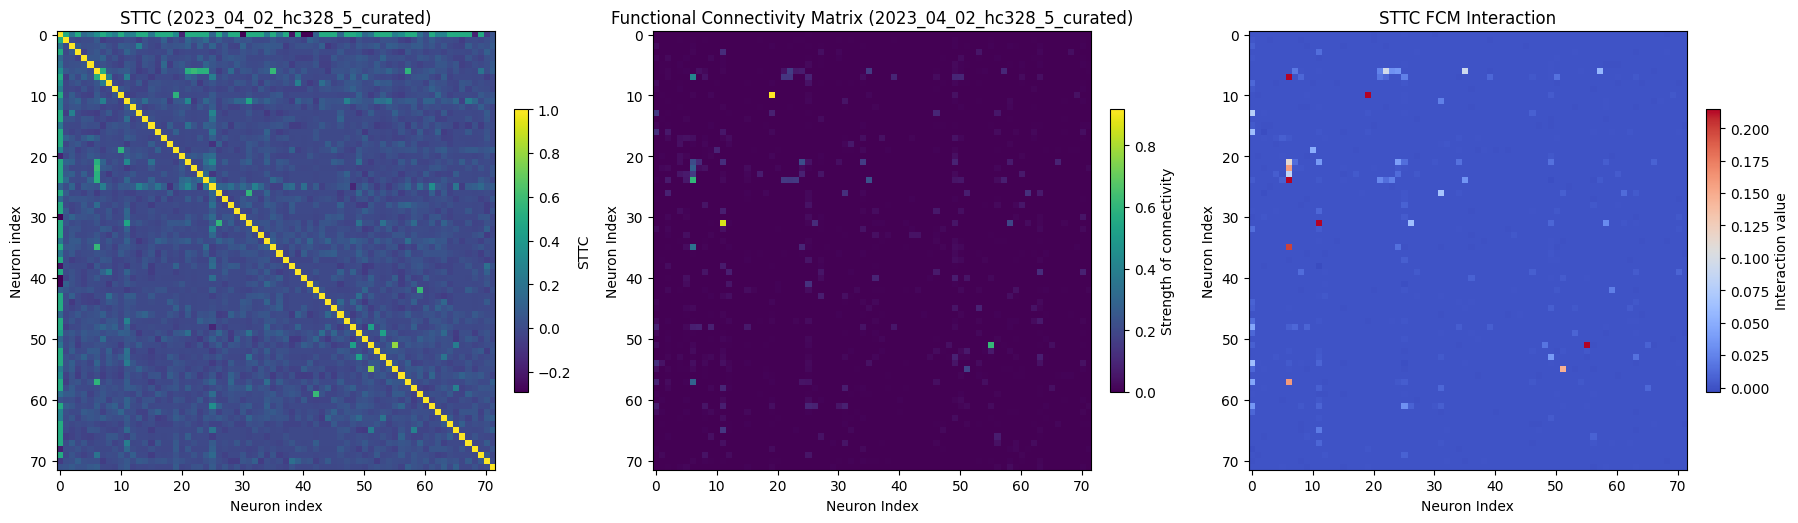

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N, sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma) 
    corr = np.corrcoef(dense_raster)
    return corr

def plot_sttc(sd):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            sttc[i][j] = sd.spike_time_tiling(i,j)
    return sttc
#     plt.imshow(sttc)
#     plt.xlabel("Neuron index")
#     plt.ylabel("Neuron index")
#     plt.show()

# Assume you have already defined sd and FC_MAT

# Get the correlation matrix from the first code
# corr_matrix = correlation(sd)
sttc_matrix = plot_sttc(sd)

# Create a 2x2 subplot arrangement
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the correlation matrix on the first subplot
heatmap1 = axs[0].imshow(sttc_matrix, cmap='viridis')
axs[0].set_title('STTC (2023_04_02_hc328_5_curated)')
axs[0].set_xlabel("Neuron index")
axs[0].set_ylabel("Neuron index")

# Plot the functional connectivity matrix on the second subplot
heatmap2 = axs[1].imshow(FC_MAT, cmap='viridis', aspect='equal')
axs[1].set_title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('Neuron Index')

# Overlay the correlation and functional connectivity matrices on the third subplot
overlay = sttc_matrix * FC_MAT
overlay_min = np.min(overlay)
overlay_max = np.percentile(overlay, 99.92)  # Adjust percentile as needed
heatmap3 = axs[2].imshow(overlay, cmap='coolwarm', aspect='equal', vmin=overlay_min, vmax=overlay_max)
axs[2].set_title('STTC FCM Interaction')
axs[2].set_xlabel('Neuron Index')
axs[2].set_ylabel('Neuron Index')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('STTC')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

colorbar3 = plt.colorbar(heatmap3, ax=axs[2], fraction=0.03, pad=0.04)
colorbar3.set_label('Interaction value')

plt.tight_layout()

plt.savefig('sttc_fcm_interaction.png')

plt.show()